In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from pyproj import CRS
import geog
import shapely
from shapely.geometry import Point
import shapely.wkt
import matplotlib.pyplot as plt
import gc

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config Completer.use_jedi = False

import warnings
warnings.filterwarnings("ignore")

We use data from various sources. Parcel data comes from Bliskapaczka.pl and Dhl. Geographical data comes from GUGIK (head office of geodesy and cartography in Poland) for poviats data. The Inspire data is from inspire-geoportal.ec.europa.eu and it represents demographic indicators for 1km2 grids. Finally, we also use data for OSM https://download.geofabrik.de/europe/poland.html to collect data for points of interest. In this part of the study, we merged all the data into datasets. What is worth mentioning is that we collect data for 3 cities: Warszawa, Poznań and Kraków, both for 1km2 grids and 500m buffers around Inpost points (only for GWR). In the case of merging for grids we took an assumption about intersection of grid with poviat (it was enough for grids to intersect with poviat boundaries). Additionally, we count other data for each grid. In turn, in the case of merging for buffers, we also count data for each buffer and also we use data from Inspire (if more than one grid intersects with buffer we take avarage value from those grids).

# Parcel data

In [2]:
bliska_paczka = pd.read_csv("../datasets/raw_data/bliska_paczka.csv", index_col=0)
bliska_paczka = bliska_paczka.loc[bliska_paczka.available == True, ("brand", "operator", "city", "street", "longitude", "latitude")]
bliska_paczka.brand = bliska_paczka.brand.str.lower()
bliska_paczka.operator = bliska_paczka.operator.str.lower()
bliska_paczka.city = bliska_paczka.city.str.lower()
bliska_paczka.street = bliska_paczka.street.str.lower()
bliska_paczka = bliska_paczka.loc[:, ("brand", "operator", "longitude", "latitude")]

In [3]:
dhl = pd.read_csv("../datasets/raw_data/dhl.csv", index_col=0)
dhl.P_TYPE = dhl.P_TYPE.str.lower() 
dhl = dhl.drop(columns=["ID"])
dhl.columns = ["brand", "latitude", "longitude"]
dhl["operator"] = "dhl"
dhl = dhl[["brand", "operator", "longitude", "latitude"]]

In [4]:
df = pd.concat([bliska_paczka, dhl], axis=0)

The table below shows the division into brands and operators.

In [5]:
display(pd.crosstab(df.brand, df.operator))

operator,dhl,dpd,fedex,inpost,poczta,ruch,ups
brand,,,,,,,
1minute,36,0,0,0,0,0,0
abc,1057,0,0,0,0,0,0
apimarket,22,0,0,0,0,0,0
biedronka_locker,147,0,0,0,0,0,0
dpd,0,3600,0,0,0,0,0
eurosklep,20,0,0,0,0,0,0
groszek,197,0,0,0,0,0,0
inmedio,374,0,0,0,0,0,0
inpost,0,0,0,15313,0,0,0


In [6]:
df = df.drop(columns=["brand"])
df = gpd.GeoDataFrame(df, geometry=[geometry.Point(xy) for xy in zip(df.longitude, df.latitude)], crs=CRS("epsg:4258"))
df = df.drop(columns=["latitude", "longitude"])

All operator points.

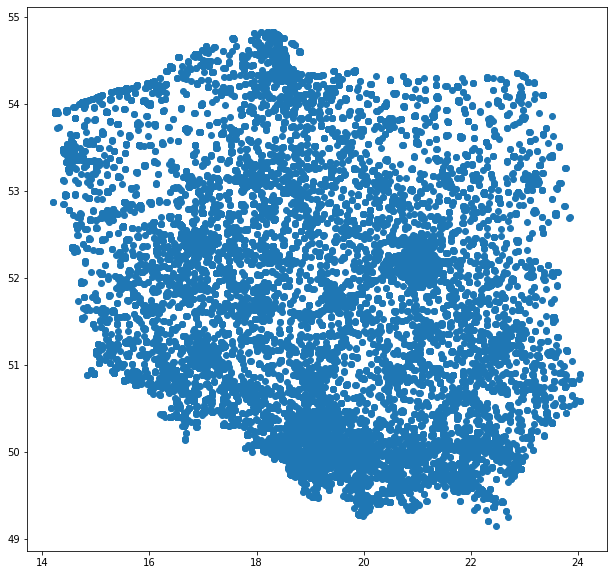

In [7]:
df.plot(figsize=(20,10))
plt.show()

In [8]:
df.head()

,operator,geometry
0,dpd,POINT (21.07175 51.25025)
1,dpd,POINT (19.21618 50.04798)
2,dpd,POINT (19.05479 52.64392)
3,dpd,POINT (20.55887 52.94742)
4,dpd,POINT (17.05318 54.46049)


In [9]:
df.to_csv('../datasets/preprocessed_data/pickup_points_by_operator.csv', index = False)

# GUGIK and Inspire data

In [10]:
pov = gpd.read_file("../datasets/raw_data/guigk_pov/Powiaty.shx", encoding='utf-8')
pov = pov.loc[pov.JPT_NAZWA_.isin(["powiat Warszawa", "powiat Kraków", "powiat Poznań"])==True, ("JPT_NAZWA_", "geometry")]
pov = pov.to_crs("epsg:4258")

grids = gpd.read_file("../datasets/raw_data/inspire/PD_STAT_GRID_CELL_2011.shp", encoding='utf-8')
grids = grids[['TOT', 'TOT_0_14', 'TOT_15_64', 'TOT_65__', 'TOT_MALE', 'TOT_FEM',
       'MALE_0_14', 'MALE_15_64', 'MALE_65__', 'FEM_0_14', 'FEM_15_64',
       'FEM_65__', 'FEM_RATIO', 'geometry']]
grids = grids.to_crs("epsg:4258")

pov_grids = gpd.sjoin(grids, pov, how="inner", op="intersects")
pov_grids = pov_grids.drop(columns=["index_right"])
pov_grids = pov_grids.reset_index()
pov_grids = pov_grids.rename(columns={"index":"grid_index"})

,grid_index,TOT,TOT_0_14,TOT_15_64,TOT_65__,TOT_MALE,TOT_FEM,MALE_0_14,MALE_15_64,MALE_65__,FEM_0_14,FEM_15_64,FEM_65__,FEM_RATIO,geometry,JPT_NAZWA_
720,206436,4841,696,3586,559,2339,2502,365,1739,235,331,1847,324,106.968790,"POLYGON ((20.85177 52.18687, 20.83728 52.18820...",powiat Warszawa
721,206464,137,19,98,20,61,76,10,46,5,9,52,15,124.590164,"POLYGON ((20.87799 52.29333, 20.86347 52.29467...",powiat Warszawa
722,206476,269,38,199,32,124,145,23,89,12,15,110,20,116.935484,"POLYGON ((20.85395 52.19574, 20.83946 52.19708...",powiat Warszawa
723,206492,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"POLYGON ((20.88018 52.30220, 20.86566 52.30354...",powiat Warszawa
724,206505,386,63,276,47,180,206,26,137,17,37,139,30,114.444444,"POLYGON ((20.87580 52.28446, 20.86129 52.28579...",powiat Warszawa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,222705,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"POLYGON ((21.27824 52.17399, 21.26377 52.17538...",powiat Warszawa
1317,222718,6,0,3,0,3,3,3,0,3,0,0,0,100.000000,"POLYGON ((21.27372 52.15627, 21.25925 52.15765...",powiat Warszawa
1318,222775,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"POLYGON ((21.27598 52.16513, 21.26151 52.16652...",powiat Warszawa
1319,222895,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"POLYGON ((21.27145 52.14740, 21.25699 52.14879...",powiat Warszawa


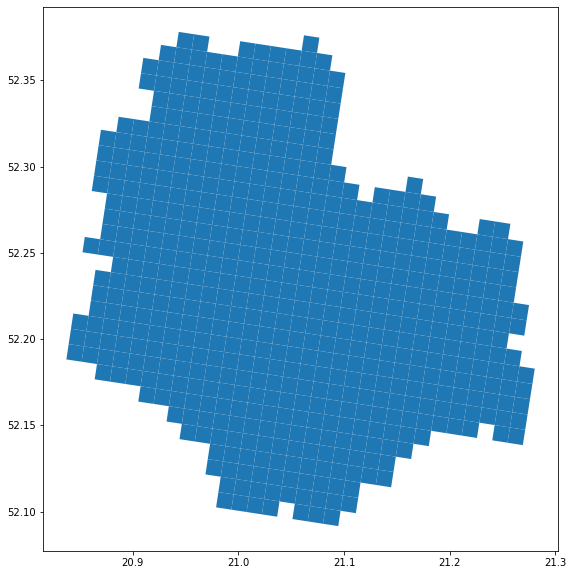

In [11]:
display(pov_grids[pov_grids.JPT_NAZWA_ == "powiat Warszawa"])

pov_grids[pov_grids.JPT_NAZWA_ == "powiat Warszawa"].plot(figsize=(20,10))
plt.show()

In [12]:
pov_grids_sliced = pov_grids[["grid_index", "geometry"]].copy() 
df_pov_grids_sliced = gpd.sjoin(df, pov_grids_sliced, how="right", op="within")
df_pov_grids_sliced = df_pov_grids_sliced.drop(columns=["index_left"])
df_pov_grids_sliced = df_pov_grids_sliced.groupby(["operator", "grid_index"], as_index=False).count()
df_pov_grids_sliced = df_pov_grids_sliced.pivot(index='grid_index', columns='operator').fillna(0).reset_index()
df_pov_grids_sliced.columns = df_pov_grids_sliced.columns.droplevel()
df_pov_grids_sliced.columns = ['grid_index', 'dhl', 'dpd', 'fedex', 'inpost', 'poczta', 'ruch', 'ups']

In [13]:
df_pov_grids = pd.merge(pov_grids, df_pov_grids_sliced, how="left", on="grid_index")
df_pov_grids.columns = df_pov_grids.columns.str.lower()
df_pov_grids = df_pov_grids.fillna(0)
df_pov_grids = df_pov_grids[['grid_index','geometry', 'jpt_nazwa_', 'dhl', 'dpd', 'fedex', 'inpost', 'poczta', 'ruch',
                             'ups', 'tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male',
                            'tot_fem', 'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14',
                            'fem_15_64', 'fem_65__', 'fem_ratio']]

In [14]:
df_pov_grids.shape

(1321, 23)

In [15]:
df_pov_grids.sample(10)

,grid_index,geometry,jpt_nazwa_,dhl,dpd,fedex,inpost,poczta,ruch,ups,tot,tot_0_14,tot_15_64,tot_65__,tot_male,tot_fem,male_0_14,male_15_64,male_65__,fem_0_14,fem_15_64,fem_65__,fem_ratio
1015,213455,"POLYGON ((21.01005 52.10864, 20.99560 52.10999...",powiat Warszawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,516,84,356,76,258,258,53,168,37,31,188,39,100.000000
440,188324,"POLYGON ((19.92454 50.07635, 19.91068 50.07756...",powiat Kraków,5.0,1.0,0.0,3.0,5.0,1.0,0.0,9101,820,6261,2020,4035,5066,414,2938,683,406,3323,1337,125.551425
542,191926,"POLYGON ((19.99084 49.98898, 19.97700 49.99020...",powiat Kraków,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400,53,304,43,206,194,28,159,19,25,145,24,94.174757
861,210445,"POLYGON ((20.98845 52.31939, 20.97392 52.32074...",powiat Warszawa,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1127,227,780,120,545,582,126,377,42,101,403,78,106.788991
1255,219936,"POLYGON ((21.22166 52.24296, 21.20717 52.24434...",powiat Warszawa,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1272,184,881,207,605,667,108,412,85,76,469,122,110.247934
414,187445,"POLYGON ((19.88568 50.02539, 19.87183 50.02659...",powiat Kraków,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87,10,64,13,35,52,3,28,4,7,36,9,148.571429
1020,213749,"POLYGON ((21.03999 52.16936, 21.02551 52.17072...",powiat Warszawa,3.0,0.0,1.0,5.0,3.0,0.0,0.0,7745,899,5407,1439,3554,4191,460,2462,632,439,2945,807,117.923467
34,60872,"POLYGON ((16.81906 52.43395, 16.80441 52.43479...",powiat Poznań,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1043,194,749,100,485,558,98,344,43,96,405,57,115.051546
283,68253,"POLYGON ((17.00423 52.29686, 16.98963 52.29772...",powiat Poznań,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,8,22,0,15,15,4,11,0,4,11,0,100.000000
512,190816,"POLYGON ((19.97624 50.05369, 19.96239 50.05491...",powiat Kraków,7.0,1.0,2.0,1.0,6.0,1.0,0.0,6551,624,4507,1420,2886,3665,328,2113,445,296,2394,975,126.992377


The table below shows the distribution of operators in each of the three cities.

,dhl,dpd,fedex,inpost,poczta,ruch,ups
jpt_nazwa_,,,,,,,
powiat Kraków,405.0,91.0,13.0,408.0,479.0,73.0,51.0
powiat Poznań,356.0,62.0,8.0,330.0,441.0,79.0,36.0
powiat Warszawa,1006.0,292.0,18.0,973.0,1128.0,278.0,153.0


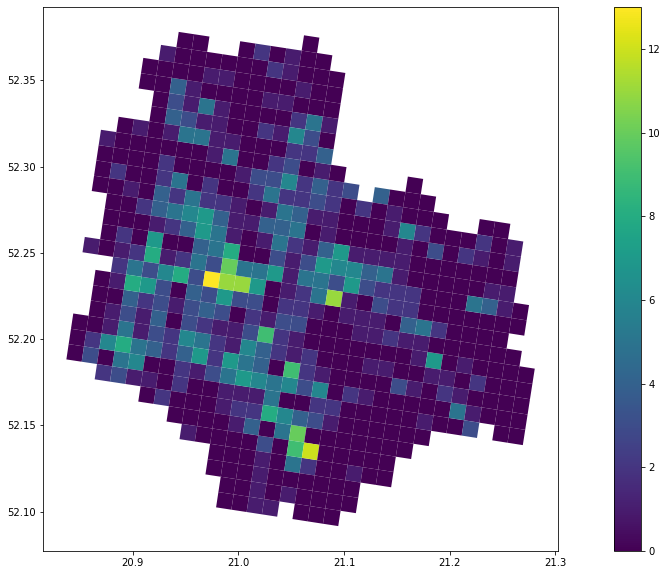

In [16]:
display(df_pov_grids.groupby("jpt_nazwa_")[['dhl', 'dpd', 'fedex', 'inpost', 'poczta', 'ruch', 'ups']].sum())

df_pov_grids[df_pov_grids.jpt_nazwa_=="powiat Warszawa"].plot(column="inpost", legend=True, figsize=(20,10))
plt.show()

In [17]:
del bliska_paczka, dhl, pov_grids, pov_grids_sliced, df_pov_grids_sliced; gc.collect();

# OSM data

In [18]:
def merging_vars(data, poviat, path):
    
    # df for concrete poviat
    df_output = data[data.jpt_nazwa_ == poviat]
    
    # loading points of interest
    buildings = gpd.read_file(path + 'gis_osm_buildings_a_free_1.shp')
    landuse = gpd.read_file(path + 'gis_osm_landuse_a_free_1.shp')
    pois_a = gpd.read_file(path + 'gis_osm_pois_a_free_1.shp')
    railways = gpd.read_file(path + 'gis_osm_railways_free_1.shp')
    roads = gpd.read_file(path + 'gis_osm_roads_free_1.shp')
    traffic_a = gpd.read_file(path + 'gis_osm_traffic_a_free_1.shp')
    traffic = gpd.read_file(path + 'gis_osm_traffic_free_1.shp')
    transport_a = gpd.read_file(path + 'gis_osm_transport_a_free_1.shp')
    
    # concrete points from above dfs
    buildings_points = buildings[buildings['type'].isin(['house', 'residential', 'bungalow', 'apartment'])][['osm_id', 'geometry']]
    shop_points = buildings[buildings['type'].isin(['supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'convenience', 'clothes', 'florist', 'chemist'])][['osm_id', 'geometry']]
    parks_points = landuse[landuse['fclass'] == 'park'][['osm_id', 'geometry']]
    forest_points = landuse[landuse['fclass'] == 'forest'][['osm_id', 'geometry']]
    schools_points = pois_a[pois_a['fclass'].isin(['school', 'playground'])][['osm_id', 'geometry']]
    railways_points = railways[['osm_id', 'geometry']]
    cycleways_points = roads[roads['fclass'] == 'cycleway'][['osm_id', 'geometry']]
    parking_points = traffic_a[traffic_a['fclass'] == 'parking'][['osm_id', 'geometry']]
    crossing_points = traffic[traffic['fclass'] == 'crossing'][['osm_id', 'geometry']]
    bus_stop_points = transport_a[transport_a['fclass'] == 'bus_stop'][['osm_id', 'geometry']]
    
    # unnecessery dfs
    del buildings, landuse, pois_a, railways, roads, traffic_a, traffic, transport_a; gc.collect()
    
    # changing crs
    buildings_points = buildings_points.to_crs("epsg:4258")
    shop_points = shop_points.to_crs("epsg:4258")
    parks_points = parks_points.to_crs("epsg:4258")
    forest_points = forest_points.to_crs("epsg:4258")
    schools_points = schools_points.to_crs("epsg:4258")
    railways_points = railways_points.to_crs("epsg:4258")
    cycleways_points = cycleways_points.to_crs("epsg:4258")
    parking_points = parking_points.to_crs("epsg:4258")
    crossing_points = crossing_points.to_crs("epsg:4258")
    bus_stop_points = bus_stop_points.to_crs("epsg:4258")
    
    # list of dataframes
    list_of_dfs = [buildings_points, shop_points, parks_points, forest_points, schools_points, railways_points,
                  cycleways_points, parking_points, crossing_points, bus_stop_points]
    
    # names of new columns
    names = ['buildings', 'shops', 'parks', 'forests', 'schools', 'railways',
                  'cycleways', 'parkings', 'crossings', 'bus_stops']
    
    # groupby points in a loop
    for i in range(len(list_of_dfs)):
        actual_point = gpd.sjoin(list_of_dfs[i], df_output, how="inner", op="intersects")
        x = actual_point[['osm_id', 'grid_index']].groupby(['grid_index']).count()
        x.rename(columns={"osm_id": names[i]}, inplace=True)
        x.reset_index(inplace = True)
        df_output = df_output.merge(x, on = 'grid_index', how='outer')
        
    df_output.fillna(0, inplace=True)
    df_output.drop(columns = {'jpt_nazwa_'}, inplace = True)

    return df_output

In [19]:
df_krakow = merging_vars(df_pov_grids, 'powiat Kraków', '../datasets/raw_data/osm_malopolskie/')
df_krakow[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']] = df_krakow[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']].astype(float)

df_krakow.to_csv('../datasets/preprocessed_data/df_krakow.csv', index = False)
df_krakow.to_file('../datasets/preprocessed_data/df_krakow.shp')
del df_krakow; gc.collect()

0

In [20]:
df_poznan = merging_vars(df_pov_grids, 'powiat Poznań', '../datasets/raw_data/osm_wielkopolskie/')
df_poznan[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']] = df_poznan[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']].astype(float)

df_poznan.to_csv('../datasets/preprocessed_data/df_poznan.csv', index = False)
df_poznan.to_file('../datasets/preprocessed_data/df_poznan.shp')
del df_poznan; gc.collect()

170

In [21]:
df_warszawa = merging_vars(df_pov_grids, 'powiat Warszawa', '../datasets/raw_data/osm_mazowieckie/')
df_warszawa[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']] = df_warszawa[['tot', 'tot_0_14', 'tot_15_64', 'tot_65__', 'tot_male', 'tot_fem',
       'male_0_14', 'male_15_64', 'male_65__', 'fem_0_14', 'fem_15_64',
       'fem_65__']].astype(float)

df_warszawa.to_csv('../datasets/preprocessed_data/df_warszawa.csv', index = False)
df_warszawa.to_file('../datasets/preprocessed_data/df_warszawa.shp')
del df_warszawa; gc.collect()

362

# Dataset for GWR

In [22]:
df_geo = df.copy()

In [23]:
df_geo['point_id'] = list(range(0, df_geo.shape[0]))

In [24]:
pov_df_geo = gpd.sjoin(pov, df_geo, how="inner", op="intersects")

In [25]:
pov_df_geo = pov_df_geo.merge(df_geo, on = 'point_id')

In [26]:
pov_df_geo = pov_df_geo.drop(columns = {'geometry_x', 'index_right', 'operator_y'})

In [27]:
pov_df_geo = pov_df_geo.rename(columns={"geometry_y": "geometry", "JPT_NAZWA_": "jpt_nazwa_", "operator_x": "operator"})

In [28]:
inpost_points = pov_df_geo[pov_df_geo['operator'] == 'inpost']

In [29]:
# creating buffer (500m radius)
def buffer(point):

    n_points = 50
    angles = np.linspace(0, 360, n_points)
    radius = 500
    polygon = geog.propagate(point, angles, radius)

    x = polygon.tolist()
    lon = list(list(zip(*x))[0])
    lat = list(list(zip(*x))[1])
    pts = gpd.GeoSeries([Point(x, y) for x, y in zip(lon, lat)])
    poly = geometry.Polygon([[p.x, p.y] for p in pts])
    polyg = gpd.GeoSeries(poly)
    

    return polyg

In [30]:
inpost_points['buffer'] = inpost_points.apply(lambda x: buffer(x['geometry']), axis=1)
inpost_points = inpost_points.rename(columns={"geometry": "center"})

In [31]:
inpost_buffers = gpd.GeoDataFrame(inpost_points, geometry = 'buffer', crs = "epsg:4258")
inpost_buffers = inpost_buffers.reset_index()
inpost_buffers = inpost_buffers.rename(columns={"index":"buffer_index"})

In [32]:
def merge_points(data_inpost, data_operator, operator):
    new_df = data_operator[data_operator['operator'] == operator]
    new_df = gpd.GeoDataFrame(new_df, geometry = 'geometry', crs = "epsg:4258")
    
    actual_point = gpd.sjoin(new_df, data_inpost, how="inner", op="intersects")
    x = actual_point[['operator_left', 'buffer_index']].groupby(['buffer_index']).count()
    x.rename(columns={"operator_left": operator+'_points'}, inplace=True)
    x.reset_index(inplace = True)
    df_output = data_inpost.merge(x, on = 'buffer_index', how='outer')
    df_output.fillna(0, inplace=True)
    
    return df_output

In [33]:
operators = ['inpost', 'poczta', 'dhl', 'ruch', 'dpd', 'ups', 'fedex']
for operator in operators:
    inpost_buffers = merge_points(inpost_buffers, pov_df_geo, operator)

In [34]:
buff = gpd.sjoin(inpost_buffers, grids, how="inner", op="intersects")

x = buff[['buffer_index', 'TOT', 'TOT_0_14', 'TOT_15_64', 'TOT_65__', 'TOT_MALE', 'TOT_FEM',
       'MALE_0_14', 'MALE_15_64', 'MALE_65__', 'FEM_0_14', 'FEM_15_64',
       'FEM_65__', 'FEM_RATIO']].groupby(['buffer_index']).mean()

inpost_buffers = inpost_buffers.merge(x, on='buffer_index')

In [35]:
def merge_osm(data, poviat, path):
    
    # df for concrete poviat
    df_output = data[data.jpt_nazwa_ == poviat]
    
    # loading points of interest
    buildings = gpd.read_file(path + 'gis_osm_buildings_a_free_1.shp')
    landuse = gpd.read_file(path + 'gis_osm_landuse_a_free_1.shp')
    pois_a = gpd.read_file(path + 'gis_osm_pois_a_free_1.shp')
    railways = gpd.read_file(path + 'gis_osm_railways_free_1.shp')
    roads = gpd.read_file(path + 'gis_osm_roads_free_1.shp')
    traffic_a = gpd.read_file(path + 'gis_osm_traffic_a_free_1.shp')
    traffic = gpd.read_file(path + 'gis_osm_traffic_free_1.shp')
    transport_a = gpd.read_file(path + 'gis_osm_transport_a_free_1.shp')
    
    # concrete points from above dfs
    buildings_points = buildings[buildings['type'].isin(['house', 'residential', 'bungalow', 'apartment'])][['osm_id', 'geometry']]
    shop_points = buildings[buildings['type'].isin(['supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'convenience', 'clothes', 'florist', 'chemist'])][['osm_id', 'geometry']]
    parks_points = landuse[landuse['fclass'] == 'park'][['osm_id', 'geometry']]
    forest_points = landuse[landuse['fclass'] == 'forest'][['osm_id', 'geometry']]
    schools_points = pois_a[pois_a['fclass'].isin(['school', 'playground'])][['osm_id', 'geometry']]
    railways_points = railways[['osm_id', 'geometry']]
    cycleways_points = roads[roads['fclass'] == 'cycleway'][['osm_id', 'geometry']]
    parking_points = traffic_a[traffic_a['fclass'] == 'parking'][['osm_id', 'geometry']]
    crossing_points = traffic[traffic['fclass'] == 'crossing'][['osm_id', 'geometry']]
    bus_stop_points = transport_a[transport_a['fclass'] == 'bus_stop'][['osm_id', 'geometry']]
    
    # unnecessery dfs
    del buildings, landuse, pois_a, railways, roads, traffic_a, traffic, transport_a; gc.collect()
    
    # changing crs
    buildings_points = buildings_points.to_crs("epsg:4258")
    shop_points = shop_points.to_crs("epsg:4258")
    parks_points = parks_points.to_crs("epsg:4258")
    forest_points = forest_points.to_crs("epsg:4258")
    schools_points = schools_points.to_crs("epsg:4258")
    railways_points = railways_points.to_crs("epsg:4258")
    cycleways_points = cycleways_points.to_crs("epsg:4258")
    parking_points = parking_points.to_crs("epsg:4258")
    crossing_points = crossing_points.to_crs("epsg:4258")
    bus_stop_points = bus_stop_points.to_crs("epsg:4258")
    
    # list of dataframes
    list_of_dfs = [buildings_points, shop_points, parks_points, forest_points, schools_points, railways_points,
                  cycleways_points, parking_points, crossing_points, bus_stop_points]
    
    # names of new columns
    names = ['buildings', 'shops', 'parks', 'forests', 'schools', 'railways',
                  'cycleways', 'parkings', 'crossings', 'bus_stops']
    
    # groupby points in a loop
    for i in range(len(list_of_dfs)):
        actual_point = gpd.sjoin(list_of_dfs[i], df_output, how="inner", op="intersects")
        x = actual_point[['osm_id', 'buffer_index']].groupby(['buffer_index']).count()
        x.rename(columns={"osm_id": names[i]}, inplace=True)
        x.reset_index(inplace = True)
        df_output = df_output.merge(x, on = 'buffer_index', how='outer')
        
    df_output.fillna(0, inplace=True)
    df_output.drop(columns = {'jpt_nazwa_'}, inplace = True)

    return df_output

In [36]:
df_krakow_inpost = merge_osm(inpost_buffers, 'powiat Kraków', '../datasets/raw_data/osm_malopolskie/')
df_krakow_inpost.to_csv('../datasets/preprocessed_data/df_krakow_gwr.csv', index = False)

In [38]:
del df_krakow_inpost; gc.collect();

In [39]:
df_poznan_inpost = merge_osm(inpost_buffers, 'powiat Poznań', '../datasets/raw_data/osm_wielkopolskie/')
df_poznan_inpost.to_csv('../datasets/preprocessed_data/df_poznan_gwr.csv', index = False)

In [41]:
del df_poznan_inpost; gc.collect();

In [42]:
df_warszawa_inpost = merge_osm(inpost_buffers, 'powiat Warszawa', '../datasets/raw_data/osm_mazowieckie/')
df_warszawa_inpost.to_csv('../datasets/preprocessed_data/df_warszawa_gwr.csv', index = False)

In [43]:
del df_warszawa_inpost; gc.collect();